In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

from env import *
from states import *
from agents import *
from models import *
from util import *

/Users/hanqiu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hanqiu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hanqiu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/hanqiu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

### Training Pipeline

#### DQN

First, train an DQN model.

In [2]:
version = 2

In [3]:
## initialize model
q_model = QModel(save_dir='model/')
q_model.learn_iter = 1
curr_iter = 0
q_model.save('dqn-v{}/{}'.format(version,curr_iter))
q_model.restore('dqn-v{}/{}'.format(version,curr_iter))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model/dqn-v2/0/model


In [4]:
## train model using DQN
agent = RlAgent(q_model)
agent.sample_collect_flag = True
agents = [agent,agent,agent,agent]

tt = time.time()
N_iter_inner = 10000
eval_freq = 1
for iter_outer in range(25):
    run_games(N_iter=N_iter_inner,agents=agents,if_train=True,models=[q_model],state_generator=StateExtend)
    q_model.save('dqn-v{}/{}'.format(version,curr_iter+(iter_outer+1)*N_iter_inner))
    q_model.partial_restore('dqn-v{}/{}'.format(version,curr_iter+(iter_outer+1)*N_iter_inner))
    print('{}:{:.2f}'.format(iter_outer+1,time.time() - tt))
    
    if iter_outer % eval_freq == 0 and iter_outer > 0:
        ## do some evaluation
        ttt = time.time()
        
        q_model_1 = QModel(save_dir='model/')
        q_model_1.partial_restore('dqn-v{}/{}'.format(version,curr_iter+(iter_outer+1-eval_freq)*N_iter_inner))
        q_model_2 = QModel(save_dir='model/')
        q_model_2.partial_restore('dqn-v{}/{}'.format(version,curr_iter+(iter_outer+1)*N_iter_inner))

        a_base = Agent()
        a_rl_1 = RlAgent(q_model_1)
        a_rl_2 = RlAgent(q_model_2)
        for a in [a_base,a_rl_1,a_rl_2]:
            a.infer_flag = True

            
        eval_results = []
        for agents_eval in [[a_rl_1,a_base,a_rl_1,a_base],
                            [a_rl_2,a_base,a_rl_2,a_base],
                            [a_rl_1,a_rl_2,a_rl_1,a_rl_2],
                            [a_rl_2,a_rl_1,a_rl_2,a_rl_1],
                          ]:
            curr_scores,eval_scores = \
                run_games(N_iter=1000,agents=agents_eval,if_random_game=False,
                          fname='dataset/valid_set_q.p',state_generator=StateExtend)
            eval_results.append(np.mean(eval_scores))
        print('{}, time:{:.2f}. eval results: {}.'.format(iter_outer,time.time()-ttt,eval_results))

INFO:tensorflow:Restoring parameters from model/dqn-v2/10000/model
1:2162.15
INFO:tensorflow:Restoring parameters from model/dqn-v2/20000/model
2:4218.92
INFO:tensorflow:Restoring parameters from model/dqn-v2/10000/model
INFO:tensorflow:Restoring parameters from model/dqn-v2/20000/model
1, time:162.48. eval results: [9.145, 8.92, -6.11, -7.625].
INFO:tensorflow:Restoring parameters from model/dqn-v2/30000/model
3:6511.63
INFO:tensorflow:Restoring parameters from model/dqn-v2/20000/model
INFO:tensorflow:Restoring parameters from model/dqn-v2/30000/model
2, time:167.81. eval results: [6.12, 4.06, 2.625, -11.755].
INFO:tensorflow:Restoring parameters from model/dqn-v2/40000/model
4:8767.75
INFO:tensorflow:Restoring parameters from model/dqn-v2/30000/model
INFO:tensorflow:Restoring parameters from model/dqn-v2/40000/model
3, time:170.46. eval results: [5.97, -0.685, -1.495, -2.705].
INFO:tensorflow:Restoring parameters from model/dqn-v2/50000/model
5:10981.62
INFO:tensorflow:Restoring para

#### MCTS

Next, train an MCTS model.

In [2]:
version = 3

In [3]:
## initialize model
mcts_model = MCTSModel(save_dir='model/')
# mcts_model.partial_restore('dqn-v2/250000')
mcts_model.save('mcts-v{}/0'.format(version))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [4]:
import pickle
import os
import glob
import ray
from tqdm import tqdm

def collect_samples(model_fname,iter_outer,N_iter_inner):
    mcts_model = MCTSModel(save_dir='model/')
    mcts_model.partial_restore(model_fname)
    e_sim = Env(Game(),DefaultPlayer(),state_generator=StateExtend)
    sample_idx = '{}-{}'.format(os.getpid(),random.getrandbits(8))
    
    agent = MCTSAgent(mcts_model,e_sim,N_search=1600)
    agent.sample_collect_flag = True
    agents = [agent,agent,agent,agent]
    N_batch = N_iter_inner
    tt = time.time()
    for iter_inner in range(N_iter_inner//N_batch):
        run_games(N_iter=N_batch,agents=agents,state_generator=StateExtend)
        with open('dataset/mcts-v{}/{}/data_sample_{}_{}.p'.format(
                    version,iter_outer,sample_idx,iter_inner),
                  'wb') as fb:
            pickle.dump(mcts_model.exp_pool,fb)
            mcts_model.clear_experience()
        print('{}-{}:{:.2f}'.format(os.getpid(),iter_inner+1,time.time() - tt))
        time.sleep(300)

@ray.remote
def collect_samples_ray(model_fname,iter_outer,N_iter_inner):
    return collect_samples(model_fname,iter_outer,N_iter_inner)

def load_exprience(model,fname):
    with open(fname,'rb') as fb:
        exp_pool = pickle.load(fb)
    model.exp_pool = exp_pool
    model.exp_pool_size = dict([(key,len(value)) for key,value in model.exp_pool.items()])
    
def ema(losses,factor=0.99):
    output = [losses[0]]
    for l in losses[1:]:
        output.append(factor * output[-1] + (1 - factor) * l)
    return output

2021-04-23 22:31:15,965	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265
(pid=80840) /Users/hanqiu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=80840)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=80840) /Users/hanqiu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=80840)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=80840) /Users/hanqiu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as 

(pid=80840) 2021-04-23 22:31:21.355049: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=80838) 2021-04-23 22:31:21.379672: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=80834) 2021-04-23 22:31:21.371419: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=80840) WARNING:tensorflow:From /Users/hanqiu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
(pid=80840) Instructions for updating:
(pid=80840) Colocations handled automatically by placer.
(pid=80838) WARNING:tensorflow:From /Users/hanqiu/anaconda3/lib/python3.6/site-packages/tensorflow

(pid=80838) 80838-1:19666.65
(pid=80840) 80840-1:19808.49
(pid=80834) 80834-1:19814.38
(pid=80841) 80841-1:19843.47
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model/mcts-v3/0/model


100%|██████████| 250/250 [43:28<00:00, 10.44s/it]


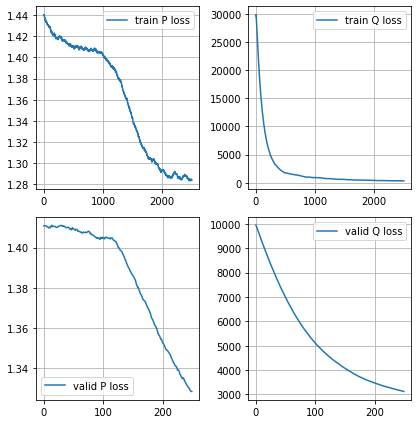

INFO:tensorflow:Restoring parameters from model/mcts-v3/0/model
INFO:tensorflow:Restoring parameters from model/mcts-v3/250/model
0, eval time:1747.11. eval results: [70.0, 52.4]
1:24516.66
(pid=80838) 80838-1:18985.30
(pid=80841) 80841-1:19226.19
(pid=80834) 80834-1:19307.41
(pid=80840) 80840-1:19372.42
INFO:tensorflow:Restoring parameters from model/mcts-v3/250/model


100%|██████████| 250/250 [43:14<00:00, 10.38s/it]


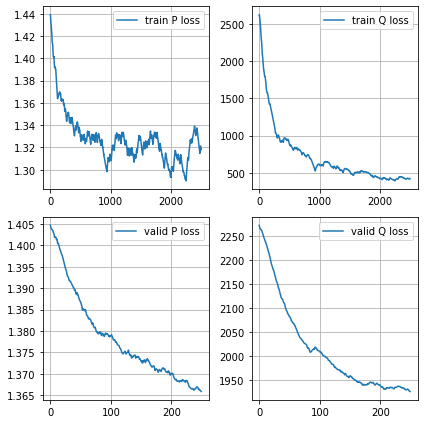

INFO:tensorflow:Restoring parameters from model/mcts-v3/250/model
INFO:tensorflow:Restoring parameters from model/mcts-v3/500/model
1, eval time:1788.01. eval results: [115.2, -9.6]
2:48582.46
(pid=80841) 80841-1:19526.25
(pid=80834) 80834-1:19573.95
(pid=80840) 80840-1:19602.43
(pid=80838) 80838-1:19602.85
INFO:tensorflow:Restoring parameters from model/mcts-v3/500/model


100%|██████████| 250/250 [44:31<00:00, 10.68s/it]


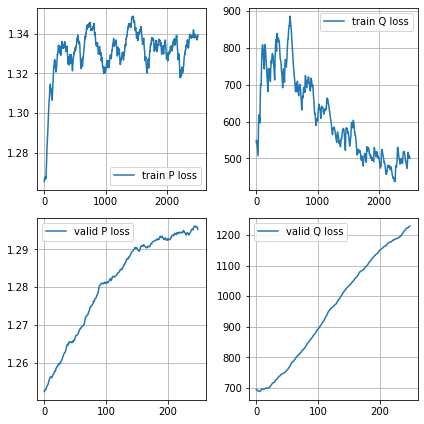

INFO:tensorflow:Restoring parameters from model/mcts-v3/500/model
INFO:tensorflow:Restoring parameters from model/mcts-v3/750/model
2, eval time:1764.88. eval results: [100.4, -6.0]
3:72933.09
(pid=80841) 80841-1:19723.48
(pid=80834) 80834-1:19838.37
(pid=80838) 80838-1:19866.61
(pid=80840) 80840-1:19914.66
INFO:tensorflow:Restoring parameters from model/mcts-v3/750/model


100%|██████████| 250/250 [43:08<00:00, 10.35s/it]


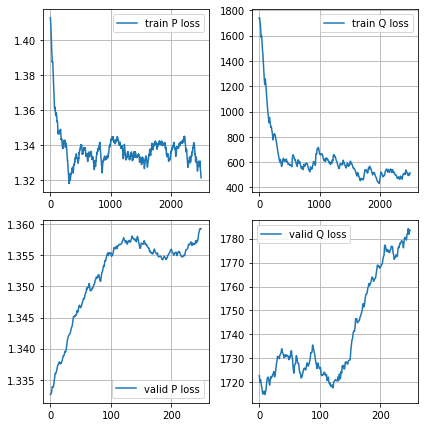

INFO:tensorflow:Restoring parameters from model/mcts-v3/750/model
INFO:tensorflow:Restoring parameters from model/mcts-v3/1000/model
3, eval time:1720.99. eval results: [112.4, -18.0]
4:97471.03
(pid=80841) 80841-1:18381.73
(pid=80840) 80840-1:18473.53
(pid=80838) 80838-1:18551.44
(pid=80834) 80834-1:18648.03
INFO:tensorflow:Restoring parameters from model/mcts-v3/1000/model


100%|██████████| 250/250 [43:43<00:00, 10.49s/it]


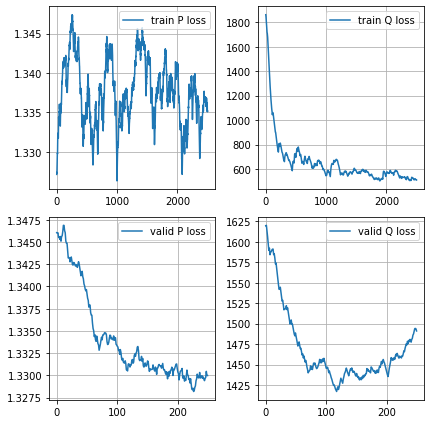

INFO:tensorflow:Restoring parameters from model/mcts-v3/1000/model
INFO:tensorflow:Restoring parameters from model/mcts-v3/1250/model
4, eval time:1726.76. eval results: [118.8, -7.6]
5:120780.78


In [5]:
## train model using MCTS
N_threads = 4
N_iter_inner = 1000 // N_threads

curr_model_iter = 0
N_iter_train_inner = 250
N_iter_train_outer = 1
valid_data_frac = 0.1
holdout_flag = True ## whether the training process has holdout valid set
factor = 0.99

tt = time.time()
ray.init()
for iter_outer in range(5):
    model_fname = 'mcts-v{}/{}'.format(version,curr_model_iter)
    
    ## collect samples
    if not os.path.exists('dataset/mcts-v{}/{}'.format(version,iter_outer)):
        os.mkdir('dataset/mcts-v{}/{}'.format(version,iter_outer))
        object_ids = [collect_samples_ray.remote(model_fname,iter_outer,N_iter_inner) for _ in range(N_threads)]
        ray.wait(object_ids, num_returns=len(object_ids))
    
    ## train models
    data_fnames_total = []
    for iter_ in range(max(iter_outer-5,0),iter_outer+1):
        data_fnames = glob.glob('dataset/mcts-v{}/{}/*.p'.format(version,iter_))
        data_fnames_total.extend(data_fnames)
    N_fnames = len(data_fnames_total)
    valid_data_fnames = [data_fnames_total[i] for i in 
                         np.random.choice(N_fnames,max(int(valid_data_frac*N_fnames),1))]
    if holdout_flag:
        data_fnames = list(set(data_fnames_total)-set(valid_data_fnames)) ## hold-out training
    else:
        data_fnames = data_fnames_total ## all training
    
    mcts_model = MCTSModel(save_dir='model/')
    mcts_model.restore(model_fname)
    mcts_model.learn_iter = 10
    prob_loss_all,q_loss_all = [],[]
    valid_prob_loss_all,valid_q_loss_all = [],[]
    
    for _ in range(N_iter_train_outer):
        for _ in tqdm(range(N_iter_train_inner)):
            data_fname = np.random.choice(data_fnames)
            load_exprience(mcts_model,data_fname)
            prob_loss_batches,q_loss_batches = mcts_model.learn()
            prob_loss_all.extend(prob_loss_batches)
            q_loss_all.extend(q_loss_batches)
            
            ## validation
            data_fname = np.random.choice(valid_data_fnames)
            load_exprience(mcts_model,data_fname)
            valid_prob_loss_batches,valid_q_loss_batches = mcts_model.eval()
            valid_prob_loss_all.extend(valid_prob_loss_batches)
            valid_q_loss_all.extend(valid_q_loss_batches)
        
        fig,axes = plt.subplots(2,2,figsize=(6,6))
        axes[0,0].plot(ema(prob_loss_all,factor),label='train P loss')
        axes[0,1].plot(ema(q_loss_all,factor),label='train Q loss')
        axes[1,0].plot(ema(valid_prob_loss_all,factor),label='valid P loss')
        axes[1,1].plot(ema(valid_q_loss_all,factor),label='valid Q loss')
        for ax in axes.ravel():
            ax.legend()
            ax.grid()
        plt.tight_layout()
        plt.show()
        
        curr_model_iter += N_iter_train_inner
        mcts_model.save('mcts-v{}/{}'.format(version,curr_model_iter))
        
    ## do some evaluation
    mcts_model_1 = MCTSModel(save_dir='model/')
    mcts_model_1.restore('mcts-v{}/{}'.format(version,curr_model_iter - N_iter_train_inner * N_iter_train_outer))
    mcts_model_2 = MCTSModel(save_dir='model/')
    mcts_model_2.restore('mcts-v{}/{}'.format(version,curr_model_iter))

    a_base = Agent()
    e_sim = Env(Game(),DefaultPlayer(),state_generator=StateExtend)
    a_mcts_1 = MCTSAgent(mcts_model_1,e_sim,N_search=1600)
    a_mcts_2 = MCTSAgent(mcts_model_2,e_sim,N_search=1600)
    for a in [a_base,a_mcts_1,a_mcts_2]:
        a.infer_flag = True

    ttt = time.time()
    eval_results = []
    for agents_eval in [
                   [a_mcts_1,a_base,a_mcts_1,a_base],
#                    [a_mcts_2,a_base,a_mcts_2,a_base],
                   [a_mcts_2,a_mcts_1,a_mcts_2,a_mcts_1],
                  ]:
        curr_scores,eval_scores = \
            run_games(N_iter=25,agents=agents_eval,if_random_game=False,
                      fname='dataset/valid_set_q.p',state_generator=StateExtend)
        eval_results.append(np.mean(eval_scores))
    print('{}, eval time:{:.2f}. eval results: {}'.format(iter_outer,time.time()-ttt,eval_results))
        
    print('{}:{:.2f}'.format(iter_outer+1,time.time() - tt))
    
ray.shutdown()

In [7]:
ray.shutdown()

##### benchmarking the learned agent

In [7]:
generate_compress_games(1000,state_generator=StateExtend,save_fname='dataset/test_set.p')

In [10]:
mcts_model_1 = MCTSModel(save_dir='model/')
mcts_model_1.restore('mcts-v3/250')
mcts_model_2 = MCTSModel(save_dir='model/')
mcts_model_2.restore('mcts-v3/1000')

INFO:tensorflow:Restoring parameters from model/mcts-v3/250/model
INFO:tensorflow:Restoring parameters from model/mcts-v3/1000/model


In [13]:
## debug
a_base = RandomAgent(seed=32)
e_sim = Env(Game(),DefaultPlayer(),state_generator=StateExtend)
a_mcts_1 = MCTSAgent(mcts_model_1,e_sim,N_search=1600,c_puct=400)
a_mcts_2 = MCTSAgent(mcts_model_2,e_sim,N_search=1600,c_puct=400)
for a in [a_base,a_mcts_1,a_mcts_2]:
    a.infer_flag = True
    a.debug_flag = True
    a.sample_collect_flag = True

ttt = time.time()
eval_results = []
agents_ref = [a_mcts_2,a_mcts_2,a_mcts_2,a_mcts_2]
for agents_eval in [
#                 [a_mcts_1,a_base,a_mcts_1,a_base],
#                 [a_mcts_2,a_base,a_mcts_2,a_base],
#                 [a_mcts_2,a_mcts_1,a_mcts_2,a_mcts_1]
                [a_mcts_1,a_mcts_1,a_mcts_1,a_mcts_1],
#                 [a_mcts_2,a_mcts_2,a_mcts_2,a_mcts_2],
              ]:
    curr_scores,eval_scores = \
        run_games_ref(N_iter=1,agents=agents_eval,agents_ref=agents_ref,if_random_game=False,if_display=True,
                  fname='dataset/test_set.p',state_generator=StateExtend)
    eval_results.append(np.mean(eval_scores))
    for _ in range(5):
        print()
print('eval time:{:.2f}; eval results:{}'.format(time.time()-ttt,eval_results))

 ♦7-->N:170,V:-23,-24,p:0.11,0.04; ♦8-->N:166,V:-22,-28,p:0.10,0.04; ♠Q-->N:120,V:-7,-24,p:0.07,0.15; ♦3-->N:107,V:-20,-14,p:0.07,0.04; ♦4-->N:103,V:-21,-27,p:0.06,0.03
*************** REF: ***************
 ♦2,♦2-->N:864,V:-9,19,p:0.54,0.06; ♦10,♦10-->N:165,V:-5,4,p:0.10,0.05; ♠A-->N:100,V:13,24,p:0.06,0.14; ☆-->N:72,V:17,26,p:0.04,0.12; ♦A,♦A-->N:65,V:13,27,p:0.04,0.09
round:0,player:3 -> ♦7, curr best ♦7. player remain: [♣5,♣8,♣Q,♥9,♥10,♥J,♥Q,♠9,♠10,♠Q,♠K,♦2,♦2,♦3,♦4,♦5,♦8,♦10,♦10,♦Q,♠A,♦A,♦A,☆],24.
 ♦6-->N:777,V:-20,-17,p:0.44,0.43; ♣A-->N:398,V:-13,-17,p:0.22,0.05; ♦Q-->N:195,V:-31,-16,p:0.11,0.22; ♦J-->N:178,V:-26,-13,p:0.10,0.15; ♥A-->N:177,V:-20,-14,p:0.10,0.09
*************** REF: ***************
 ♦6-->N:935,V:14,15,p:0.58,0.46; ♦Q-->N:218,V:5,-6,p:0.13,0.23; ♦J-->N:162,V:9,8,p:0.10,0.13; ♦9-->N:123,V:15,8,p:0.08,0.04; ♥A-->N:118,V:7,-7,p:0.07,0.11
round:0,player:0 -> ♦6, curr best ♦7. player remain: [♣10,♣J,♣Q,♥2,♥2,♥3,♥4,♥7,♥J,♥K,♠2,♠2,♠4,♠5,♠6,♠7,♠8,♠J,♠J,♦9,♦J,♦Q,♣A,♥A],24.

 ♠J,♠J-->N:1509,V:70,40,p:0.80,0.05; ♥K-->N:114,V:40,32,p:0.06,0.20; ♣J-->N:36,V:20,19,p:0.02,0.11; ♠8-->N:34,V:23,21,p:0.02,0.09; ♠6-->N:32,V:22,22,p:0.02,0.09
round:4,player:0 -> ♥K, curr best ♥K. player remain: [♣10,♣J,♣Q,♥3,♥4,♥7,♥J,♠2,♠2,♠4,♠5,♠6,♠7,♠8,♠J,♠J,♦9,♦J,♦Q],19.
 ♥7-->N:768,V:50,43,p:0.28,0.10; ♥5-->N:759,V:55,38,p:0.28,0.30; ♥10-->N:535,V:56,33,p:0.20,0.24; ♥Q-->N:501,V:56,45,p:0.19,0.22; ♥K-->N:143,V:67,41,p:0.05,0.13
*************** REF: ***************
 ♥Q-->N:445,V:41,56,p:0.26,0.22; ♥7-->N:413,V:41,51,p:0.24,0.20; ♥10-->N:401,V:43,37,p:0.23,0.24; ♥5-->N:240,V:41,44,p:0.14,0.11; ♥K-->N:214,V:51,35,p:0.12,0.23
round:4,player:1 -> ♥7, curr best ♥K. player remain: [♣3,♣4,♣5,♣7,♣8,♣9,♥5,♥10,♥Q,♥K,♠3,♠8,♠9,♠10,♠Q,♠K,♦4,♦9,♦K],19.
 ♥5-->N:2150,V:57,40,p:0.91,0.80; ♥4-->N:217,V:46,45,p:0.09,0.20
*************** REF: ***************
 ♥5-->N:1958,V:61,42,p:0.97,0.86; ♥4-->N:54,V:21,21,p:0.03,0.14
round:4,player:2 -> ♥5, curr best ♥K. player remain: [♣2,♣2,♣6,♣7,♣9,♣10,♣J,♣K,

 ♣9-->N:1041,V:113,108,p:0.50,0.20; ♣7-->N:426,V:108,101,p:0.20,0.19; ♠A-->N:93,V:93,99,p:0.04,0.12; ♣2,♣2-->N:93,V:104,108,p:0.04,0.06; ☆☆-->N:89,V:99,102,p:0.04,0.08
*************** REF: ***************
 ♦J-->N:472,V:136,146,p:0.27,0.10; ☆-->N:209,V:135,142,p:0.12,0.06; ♠A-->N:197,V:133,131,p:0.11,0.08; ☆☆-->N:179,V:130,139,p:0.10,0.10; ♦5-->N:170,V:129,143,p:0.10,0.10
round:9,player:2 -> ♣9, curr best ♣9. player remain: [♣2,♣2,♣6,♣7,♥4,♦5,♦J,♥A,♠A,☆,☆☆],11.
*************** REF: ***************
round:9,player:3 -> ♣5, curr best ♣9. player remain: [♥9,♦2,♦3,♦4,♦5,♦10,♦10,♦Q,♦A,♦A,☆],11.
*************** REF: ***************
round:9,player:0 -> ♣Q, curr best ♣Q. player remain: [♥3,♥4,♥7,♥J,♠4,♠5,♠7,♠8,♦9,♦J,♦Q],11.
 ♣7-->N:1112,V:110,98,p:0.42,0.25; ♣8-->N:596,V:114,101,p:0.23,0.24; ♣5-->N:479,V:117,105,p:0.18,0.27; ♣9-->N:451,V:117,107,p:0.17,0.25
*************** REF: ***************
 ♣8-->N:715,V:117,111,p:0.42,0.31; ♣7-->N:476,V:120,115,p:0.28,0.29; ♣5-->N:278,V:124,120,p:0.16,0.22; 

 ♠8,♦9-->N:833,V:81,93,p:0.35,0.32; ♥3,♦9-->N:621,V:80,99,p:0.26,0.27; ♠4,♦9-->N:394,V:80,97,p:0.17,0.17; ♥7,♦9-->N:388,V:81,94,p:0.16,0.14; ♠5,♦9-->N:137,V:75,97,p:0.06,0.09
round:14,player:0 -> ♠8,♦9, curr best ♦A,♦A. player remain: [♥3,♥7,♠4,♠5],4.
 ♥5,♦4-->N:1283,V:75,88,p:0.49,0.31; ♠10,♦4-->N:497,V:77,87,p:0.19,0.16; ♥Q,♦4-->N:354,V:84,86,p:0.14,0.24; ♣8,♦4-->N:265,V:81,89,p:0.10,0.14; ♣9,♦4-->N:209,V:86,95,p:0.08,0.16
*************** REF: ***************
 ♠10,♦4-->N:1365,V:74,91,p:0.56,0.24; ♥5,♦4-->N:553,V:81,94,p:0.23,0.30; ♥Q,♦4-->N:270,V:86,97,p:0.11,0.22; ♣8,♦4-->N:152,V:88,101,p:0.06,0.13; ♣9,♦4-->N:92,V:91,101,p:0.04,0.10
round:14,player:1 -> ♥5,♦4, curr best ♦A,♦A. player remain: [♣8,♣9,♥Q,♠10],4.
 ♥A,☆-->N:1061,V:73,84,p:0.37,0.38; ♦5,☆-->N:1010,V:73,83,p:0.35,0.36; ♦5,♥A-->N:811,V:73,81,p:0.28,0.26
*************** REF: ***************
 ♦5,☆-->N:878,V:83,83,p:0.41,0.34; ♦5,♥A-->N:723,V:82,84,p:0.34,0.27; ♥A,☆-->N:551,V:76,84,p:0.26,0.39
round:14,player:2 -> ♥A,☆, curr b

In [11]:
mcts_model_1.sess.run(mcts_model_1.temp_eval)

-2.5547822

In [8]:
mcts_model_2.sess.run(mcts_model_2.temp_eval)

-2.3583157

In [12]:
a_base = Agent()
e_sim = Env(Game(),DefaultPlayer(),state_generator=StateExtend)
a_mcts_1 = MCTSAgent(mcts_model_1,e_sim,N_search=1600)
a_mcts_2 = MCTSAgent(mcts_model_2,e_sim,N_search=1600)
for a in [a_base,a_mcts_1,a_mcts_2]:
    a.infer_flag = True

ttt = time.time()
eval_results = []
for agents_eval in [
#                 [a_mcts_1,a_base,a_mcts_1,a_base],
#                 [a_mcts_2,a_base,a_mcts_2,a_base],
                [a_mcts_2,a_mcts_1,a_mcts_2,a_mcts_1],
                [a_mcts_1,a_mcts_2,a_mcts_1,a_mcts_2],
              ]:
    curr_scores,eval_scores = \
        run_games(N_iter=100,agents=agents_eval,if_random_game=False,
                  fname='dataset/test_set.p',state_generator=StateExtend)
    eval_results.append(np.mean(eval_scores))
print('eval time:{:.2f}; eval results:{}'.format(time.time()-ttt,eval_results))

eval time:9287.43; eval results:[20.85, -15.2]


##### check whether the model learns well

In [8]:
## load the trained model
def softmax(arr):
    prob = np.exp(arr - np.max(arr))
    prob = prob / np.sum(prob)
    return prob

def eval_ent(arr):
    return np.sum(arr * np.log(np.maximum(arr,1e-8)))

mcts_model = MCTSModel(save_dir='model/')
mcts_model.restore('mcts-v{}/{}'.format(version,curr_model_iter))

data_fnames = glob.glob('dataset/mcts-v{}/{}/*.p'.format(version,iter_outer))
data_fname = np.random.choice(data_fnames)
load_exprience(mcts_model,data_fname)
dataset = mcts_model.exp_pool[0]

INFO:tensorflow:Restoring parameters from model/mcts-v1/1250/model


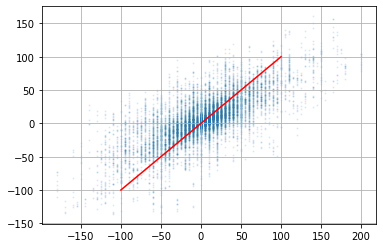

In [9]:
## do a batch inference
prob_loss_batches = []
prob_real_batches,value_real_batches = [],[]
logit_pred_batches,prob_pred_batches,value_pred_batches = [],[],[]
for exp in dataset:
    s_batch,As_batch,direc_batch,mask_len_batch,value_batch,probs_batch = [],[],[],[],[],[]
    for sample in [exp]:
        state_vec,actions_vec,direc,value,a_probs = sample
        mask_len_batch.append(actions_vec.shape[1])
    max_len = np.max(mask_len_batch)

    for sample in [exp]:
        state_vec,actions_vec,direc,value,a_probs = sample

        s_batch.append(state_vec)
        direc_batch.append(direc)
        value_batch.append(value)

        n_pad = max_len - actions_vec.shape[1]
        if n_pad > 0:
            actions_vec = np.concatenate([actions_vec,np.zeros((1,n_pad,55))],axis=1)
            a_probs = np.concatenate([a_probs,np.zeros((n_pad,))],axis=0)

        As_batch.append(actions_vec)
        probs_batch.append(a_probs)

    value_pred_batch,logit_pred_batch,prob_loss_batch = \
        mcts_model.sess.run([mcts_model.v_s_eval,mcts_model.logits_sAs_eval,
                                                            mcts_model.prob_loss],
                                {mcts_model.tfs:np.concatenate(s_batch,axis=0),
                                 mcts_model.tfAs:np.concatenate(As_batch,axis=0),
                                 mcts_model.tfprobs_sAs:np.stack(probs_batch,axis=0),
                                 mcts_model.tfv_s:np.array(value_batch),
                                 mcts_model.tfmask_len:np.array(mask_len_batch),
                                 mcts_model.tf_direc:np.array(direc_batch),
                                })
    prob_loss_batches.append(prob_loss_batch)
    logit_pred_batches.append((logit_pred_batch))
    prob_pred_batches.append(softmax(logit_pred_batch))
    value_pred_batches.append(value_pred_batch)
    prob_real_batches.append(np.stack(probs_batch,axis=0))
    value_real_batches.append(np.array(value_batch))
    
prob_loss_batches = np.array(prob_loss_batches)
value_pred_batches = np.array(value_pred_batches)
value_real_batches = np.array(value_real_batches)

plt.figure()
plt.scatter(value_real_batches[:,0],value_pred_batches[:,0],1,alpha=0.1)
plt.plot([-100,100],[-100,100],'r')
plt.grid()
plt.show()

#### Speed Tests

In [ ]:
test_fname = 'dataset/speed_test_set.p'

In [ ]:
## load models
mcts_model = MCTSModel(save_dir='model/')
e_sim = Env(Game(),DefaultPlayer(),state_generator=StateExtend)
agent = MCTSAgent(mcts_model,e_sim,N_search=1600)
agent.sample_collect_flag = True
agents = [agent,agent,agent,agent]

In [ ]:
%%prun -s cumulative -l 50

_ = run_games(agents=agents,fname=test_fname,state_generator=StateExtend)

In [ ]:
%load_ext line_profiler

# %lprun -f agent.mcts_search run_games(agents=agents,fname=test_fname,state_generator=StateExtend)
%lprun -f agent.predict_node_batch run_games(agents=agents,fname=test_fname,state_generator=StateExtend)